# Capstone Project 3

## Early Diabetes Detection

Data Source:  UCI Center for Machine Learning http://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.#


In [1]:
# packages
import os
import pandas as pd
import numpy  as np
import csv
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=DeprecationWarning)
#    import sklearn
# required machine learning packages
from sklearn import model_selection
from sklearn import linear_model, tree, discriminant_analysis, naive_bayes, ensemble, gaussian_process
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

#from sklearn.feature_selection import RFE
#from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import xgboost as xgb

In [2]:
df = pd.read_csv("Capstone3 Early Diabetes Detection.csv")

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   Sudden Weight Loss  520 non-null    object
 5   Weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital Thrush      520 non-null    object
 8   Visual Blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  Delayed Healing     520 non-null    object
 12  Partial Paresis     520 non-null    object
 13  Muscle Stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  Class               520 no

,Age,Gender,Polyuria,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Obesity,Class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [4]:
# Convert Yes/No            to integers 1/0
#         Female/Male       to integers 1/0
#         Positive/Negative to integers 1/0
df.replace(['Yes', 'No', 'Female', 'Male', 'Positive', 'Negative'], 
           [    1 ,  0 ,       1 ,     0 ,         1 ,         0 ], inplace=True)

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 520 non-null    int64
 1   Gender              520 non-null    int64
 2   Polyuria            520 non-null    int64
 3   Polydipsia          520 non-null    int64
 4   Sudden Weight Loss  520 non-null    int64
 5   Weakness            520 non-null    int64
 6   Polyphagia          520 non-null    int64
 7   Genital Thrush      520 non-null    int64
 8   Visual Blurring     520 non-null    int64
 9   Itching             520 non-null    int64
 10  Irritability        520 non-null    int64
 11  Delayed Healing     520 non-null    int64
 12  Partial Paresis     520 non-null    int64
 13  Muscle Stiffness    520 non-null    int64
 14  Alopecia            520 non-null    int64
 15  Obesity             520 non-null    int64
 16  Class               520 non-null    int64
dt

,Age,Gender,Polyuria,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Obesity,Class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


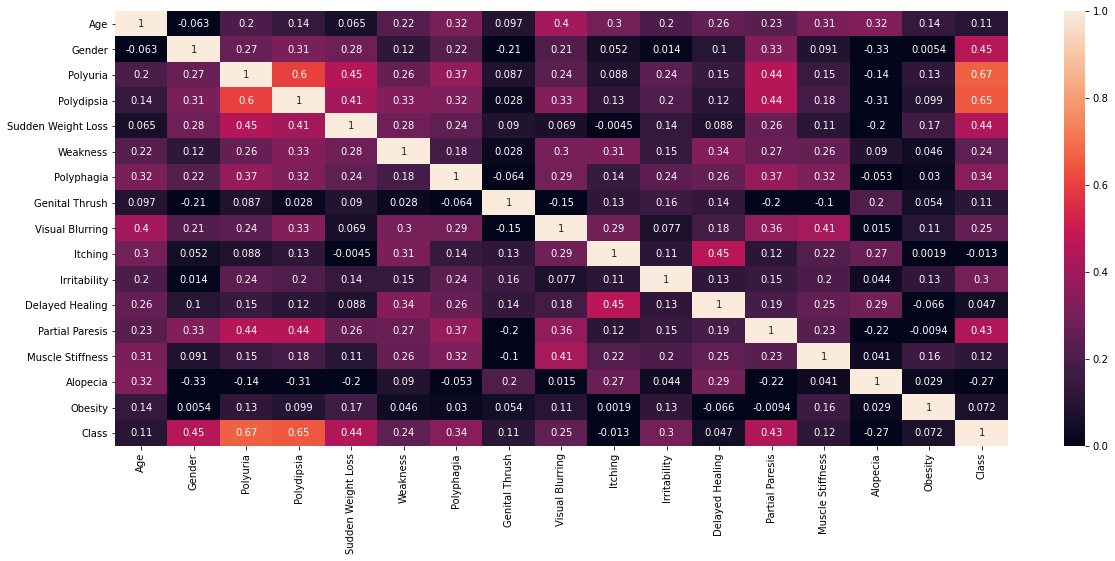

In [6]:
feature_cols = df[['Age',
                   'Gender',
                   'Polyuria',
                   'Polydipsia',
                   'Sudden Weight Loss',
                   'Weakness',
                   'Polyphagia', 
                   'Genital Thrush', 
                   'Visual Blurring', 
                   'Itching', 
                   'Irritability', 
                   'Delayed Healing', 
                   'Partial Paresis',
                   'Muscle Stiffness', 
                   'Alopecia', 
                   'Obesity', 
                   'Class']]

plt.subplots(figsize=(20,8))
sns.heatmap(feature_cols.corr(), annot=True, vmin=0, vmax=1);

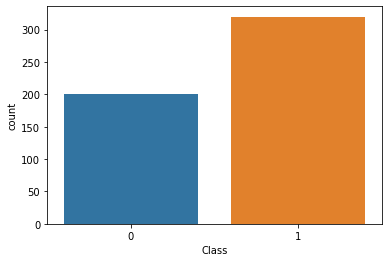

In [7]:
import seaborn as sns
sns.countplot(df['Class'],label="Count")

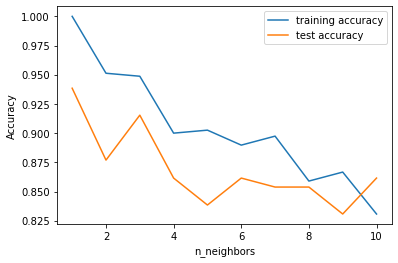

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Class'], df['Class'], stratify=df['Class'], random_state=66)
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

In [9]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.86
Accuracy of K-NN classifier on test set: 0.85


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

print("Training set score: {:.3f}".format(pipe.score(X_train, y_train)))
print("Test set score: {:.3f}".format(pipe.score(X_test, y_test)))

Training set score: 0.923
Test set score: 0.954


In [11]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.954


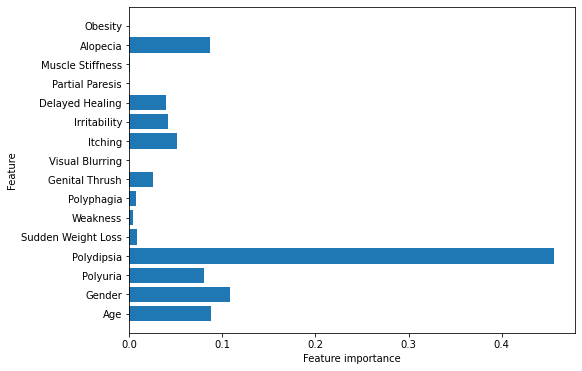

In [12]:
def plot_feature_importances_diabetes(model):
    plt.figure(figsize=(8,6))
    n_features = 16
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), diabetes_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
diabetes_features = [x for i,x in enumerate(df.columns) if i!=16]
plot_feature_importances_diabetes(tree)
plt.savefig('tree_feature_importance')

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.969


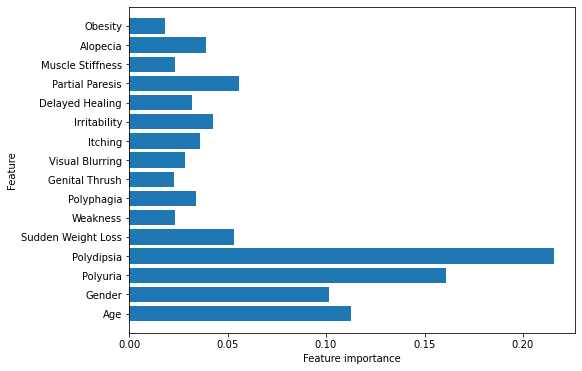

In [14]:
plot_feature_importances_diabetes(rf)
plt.savefig('rf_feature_importance')

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.985


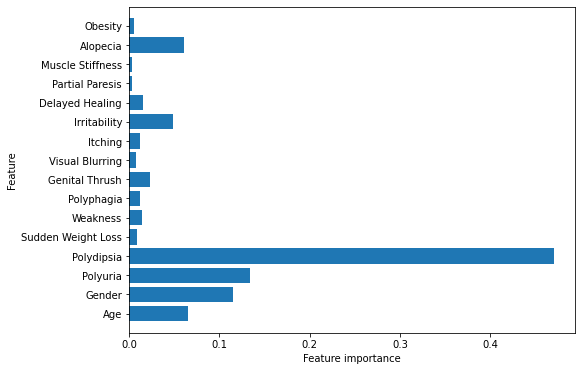

In [16]:
plot_feature_importances_diabetes(gb)
plt.savefig('gb_feature_importance')

In [17]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.62
Accuracy on test set: 0.62


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
svc = SVC()
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.98
Accuracy on test set: 0.99
